Author: Tristan Bailey

Import Libraries

In [1]:
import torch
import os
import matplotlib.pyplot as plt
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

Verify System has Cuda Capability

In [2]:
has_cuda = False
if torch.cuda.is_available():
    print("CUDA is available!")
    print("Will utilize GPU acceleration")
else:
    print("CUDA is not available.")

CUDA is available!
Will use GPU Acceleration


In [9]:
labels_map = {
    0 : "Bump",
    1 : "Crack",
    2 : "Plain",
    3 : "Pot Hole",
    4 : "Speed Bump"
}
num_epochs = 10
model_name = "Resnet_10batch.pth"

Training Data Directory

In [3]:
cwd = os.getcwd()
#the folder directory that has the image folders
data_dir_name = "training_data"
training_data_path = os.path.join(cwd, data_dir_name)
print(training_data_path)

C:\Users\duela.LAPTOP-AG0V9VDS.000\Documents\School\Year 4\Spring-2023\CS426_Capstone\taining\training_data


Define Transformation and Dataset Creation

In [4]:
class AddGaussianNoise(object):
    def __init__(self, mean=0, std=1., p=0.5):
        self.mean = mean
        self.std = std
        self.p = p
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1}, p={0.5})'.format(self.mean, self.std, self.p)

In [6]:
# Define the transformations to be applied to each image
transform_original = transforms.Compose([
    #grayscale the image as the inference will only work with grayscale data
    transforms.Grayscale(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    #reduce overfitting
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([AddGaussianNoise(p=0.10)])
])

transform_augmented = transforms.Compose([
    #grayscale the image as the inference will only work with grayscale data
    transforms.Grayscale(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    #image augmentation to increase dataset and reduce overfitting
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=25),
    #transforms.ColorJitter(brightness=(0.9, 1.2), contrast=1, saturation=0.8, hue=0.1),
    transforms.RandomApply([AddGaussianNoise(p=0.5)])])

transform = transforms.Compose([transforms.RandomChoice([transform_original, transform_augmented], p=[.75, .25])])
# Create the dataset using the ImageFolder class
dataset_original = datasets.ImageFolder(root=training_data_path, transform=transform)
training_data = dataset_original

Load Dataset

In [7]:
# Create a data loader for the dataset
dataloader = data.DataLoader(training_data, batch_size=32, shuffle=True, num_workers=4)

Display Samples from Dataset

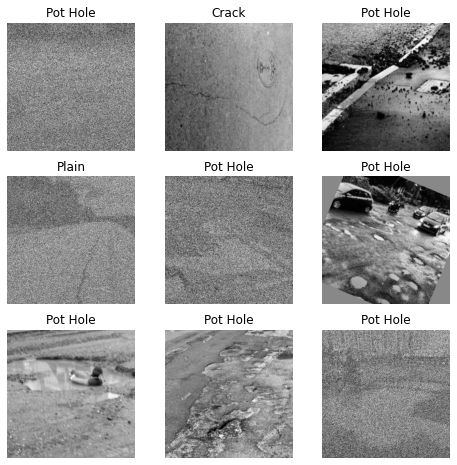

In [10]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Import Generic Pre-Trained Model

In [13]:
#load pretrained model(Image Net)
resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
#remove final classifier layer, will update for our programs classes
modules = list(resnet.children())[:-1]
resnet = nn.Sequential(*modules)

Extend Model for Grayscale

In [15]:
#lock all layers but FC final layer
for param in resnet.parameters():
    param.requires_grad = False
for name, module in resnet.named_modules():
    print(name, module)
#resnet.fc.requires_grad = True

 Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Co

In [ ]:
#move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet.to(device)

Optimizer

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.fc.parameters(), lr=0.001, momentum=0.9)

Fine-Tune Model

In [ ]:
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished fine-tuning the model.')

Save Model as Binary

In [ ]:
torch,save(resnet.state_dict(), os.path.join(cwd, model_name))